In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import seaborn as sn

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [4]:
test_data = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [5]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [6]:
class_names = ['plane', '  car', ' bird', '  cat',
               ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']


In [7]:
for images, labels in train_loader:
    break

In [8]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

Label: [1 5 8 1 6 1 6 3 7 9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


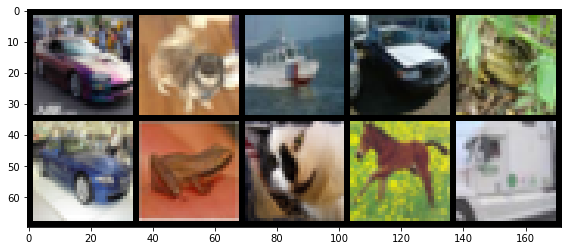

In [9]:
# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

In [10]:
class ConvolutionalNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1) # (1,6,5,1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

In [11]:
torch.manual_seed(101)

model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
import time

start_time = time.time()

# VARIABLES (TRACKERS)
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# FOR LOOP EPOCHS
for i in range(epochs):

    trn_corr = 0
    tst_corr = 0

    # run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        # apply the model
        y_pred = model(X_train) # no need to flatten
        loss = criterion(y_pred, y_train)

        # tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()   # True 1 / False 0 sum()
        trn_corr += batch_corr

        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print the interim results
        if b%600 == 0:
            print(f"Epoch: {i} Batch: {b} Loss: {loss.item()}")

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # apply the model
            y_val = model(X_test)

            # tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

current_time = time.time()

total = current_time - start_time
print(f"Training took {total / 60} minutes")

Epoch: 0 Batch: 600 Loss: 1.7282367944717407
Epoch: 0 Batch: 1200 Loss: 1.5864254236221313
Epoch: 0 Batch: 1800 Loss: 1.0029999017715454
Epoch: 0 Batch: 2400 Loss: 1.5707143545150757
Epoch: 0 Batch: 3000 Loss: 1.0078243017196655
Epoch: 0 Batch: 3600 Loss: 1.9980099201202393
Epoch: 0 Batch: 4200 Loss: 1.2217363119125366
Epoch: 0 Batch: 4800 Loss: 1.2372149229049683
Epoch: 1 Batch: 600 Loss: 2.2649588584899902
Epoch: 1 Batch: 1200 Loss: 1.3796510696411133
Epoch: 1 Batch: 1800 Loss: 1.5295768976211548
Epoch: 1 Batch: 2400 Loss: 1.0470213890075684
Epoch: 1 Batch: 3000 Loss: 1.339155673980713
Epoch: 1 Batch: 3600 Loss: 2.4084112644195557
Epoch: 1 Batch: 4200 Loss: 1.1443965435028076
Epoch: 1 Batch: 4800 Loss: 0.9166296124458313
Epoch: 2 Batch: 600 Loss: 1.2199771404266357
Epoch: 2 Batch: 1200 Loss: 1.781209945678711
Epoch: 2 Batch: 1800 Loss: 0.9163333177566528
Epoch: 2 Batch: 2400 Loss: 1.1040372848510742
Epoch: 2 Batch: 3000 Loss: 1.6629070043563843
Epoch: 2 Batch: 3600 Loss: 1.5702756643

In [15]:
torch.save(model.state_dict(), 'myCIFARModel.pt')

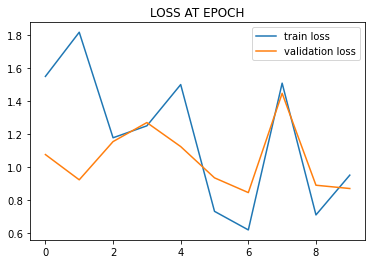

In [16]:
with torch.no_grad():
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='validation loss')
    plt.title('LOSS AT EPOCH')
    plt.legend()

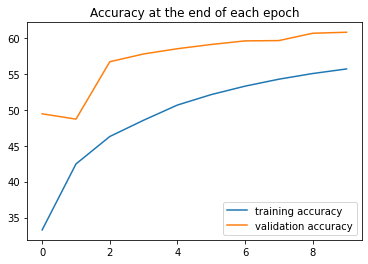

In [17]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [18]:
print(test_correct)

[tensor(4943), tensor(4869), tensor(5667), tensor(5775), tensor(5848), tensor(5907), tensor(5957), tensor(5961), tensor(6063), tensor(6077)]


In [21]:
num_c = test_correct[-1].item()

In [22]:
num_c * 100 / 10000

60.77

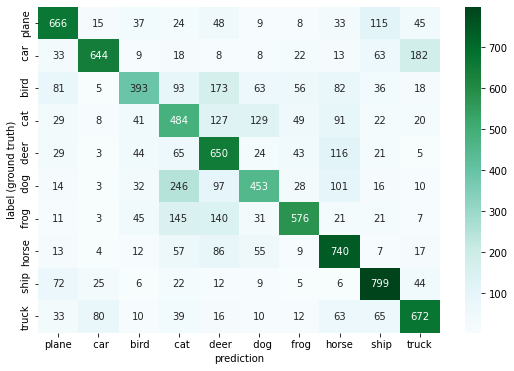

In [25]:
# confusion matrix

test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()